In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras_tuner as kt
import tensorflow as tf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split

## Step 1 ##

Let us consider the stock Asian Paints, which is traded on the Indian stock markets. We download the data from yfinance for the past 8 years.

In [246]:
data = yf.Ticker("ASIANPAINT.NS").history(period="8y")

In [248]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-02-20 00:00:00+05:30,907.051664,924.937866,900.303026,920.973633,1092302,0.0,0.0
2017-02-21 00:00:00+05:30,922.814069,938.151829,921.492639,935.839355,885074,0.0,0.0
2017-02-22 00:00:00+05:30,939.237244,968.166643,938.104656,963.022583,2809160,0.0,0.0
2017-02-23 00:00:00+05:30,972.178164,972.178164,948.911935,952.357056,1580357,0.0,0.0
2017-02-27 00:00:00+05:30,953.300900,961.370911,942.918415,945.702820,738246,0.0,0.0


In [250]:
data.shape #less than 2000 rows of data, as stated in the GWP

(1978, 7)

For the analysis that follows, we consider just the closing price

In [253]:
data = data["Close"]
data.head()

Date
2017-02-20 00:00:00+05:30    920.973633
2017-02-21 00:00:00+05:30    935.839355
2017-02-22 00:00:00+05:30    963.022583
2017-02-23 00:00:00+05:30    952.357056
2017-02-27 00:00:00+05:30    945.702820
Name: Close, dtype: float64

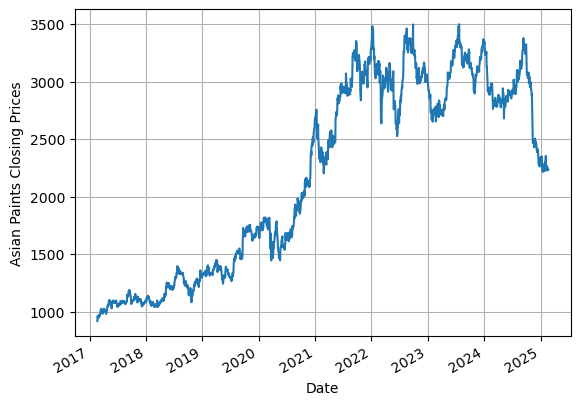

In [9]:
#Plot the time series
data.plot(ylabel="Asian Paints Closing Prices")
plt.grid()

The plot clearly shows a trend in the time series. The prices of the Asian Paints stock clearly rises with time.

In [11]:
data.describe() #summary statistics for the untransformed time series

count    1978.000000
mean     2195.693018
std       827.235237
min       920.973633
25%      1331.915833
50%      2324.104126
75%      2986.692200
max      3497.630127
Name: Close, dtype: float64

Note that the series has a high standard deviation of 827.44, and a mean of 2196.67.

Text(0.5, 1.0, 'Histogram of Asian Paints Closing Price')

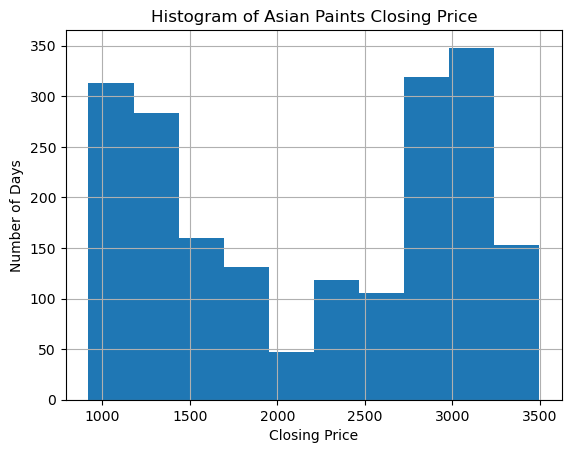

In [13]:
data.hist(bins = 10)
plt.xlabel("Closing Price")
plt.ylabel("Number of Days")
plt.title("Histogram of Asian Paints Closing Price")

Let us check for the presence of autocorrelation in the time series with different lags

In [15]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(data.autocorr(lag = i))

0.9991062601228302
0.995196874948592
0.9905199470772578
0.9484417749173853
0.9148168463755268
0.8848048746025199
0.6535425926992952
-0.3485162814573803


As you can see, the time series is heavily autocorrelated

Let us test for stationarity using the Augmented Dickey-Fuller test

In [18]:
adf_result_data = adfuller(data)
adf_statistic = adf_result_data[0] 
p_value = adf_result_data[1]
used_lags = adf_result_data[2] 
critical_values = adf_result_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.5742522314695544,
 0.49651323221834676,
 1,
 {'1%': -3.4336636717018405,
  '5%': -2.8630037919874423,
  '10%': -2.567549261922421})

Note that the adf_statistic of -1.57 is higher than all the critical values. The p-value is 0.49 which is greater than 0.05. This means that we fail to reject the null hypothesis (that the series has a unit root). So, the untransformed time series for the Asian Paints NSE stock can be said be non-stationary.

In [20]:
differenced_data = data.diff()[1:]

In [21]:
differenced_data.head()

Date
2017-02-21 00:00:00+05:30    14.865784
2017-02-22 00:00:00+05:30    27.183167
2017-02-23 00:00:00+05:30   -10.665588
2017-02-27 00:00:00+05:30    -6.654114
2017-02-28 00:00:00+05:30    21.000977
Name: Close, dtype: float64

Text(0, 0.5, 'Differenced Prices [Lag 1]')

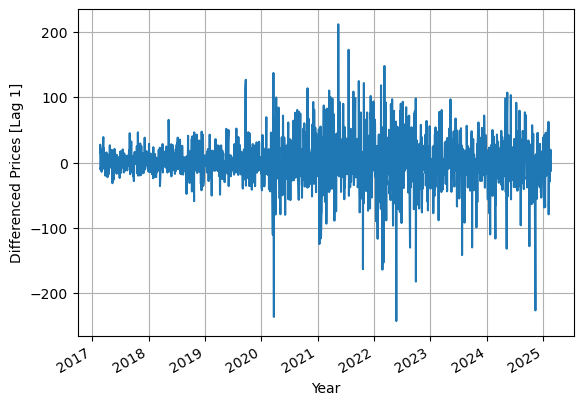

In [22]:
differenced_data.plot()
plt.grid()
plt.xlabel("Year")
plt.ylabel("Differenced Prices [Lag 1]")

In [23]:
for i in [1, 5, 10, 50, 100, 200, 500, 1000]:
    print(differenced_data.autocorr(lag = i))

0.04830875698088348
-0.013929503884396422
0.0014293909867304046
-0.06208304160700408
-0.06341200576433872
0.00403445504050491
-0.014941984903887113
0.020470257303734453


In [24]:
differenced_data.describe()

count    1977.000000
mean        0.664606
std        34.976198
min      -242.193848
25%       -13.579834
50%         0.394775
75%        15.985962
max       211.206787
Name: Close, dtype: float64

The differenced time series seems to be de-trended now. Let us now test for stationarity.

In [26]:
adf_result_differenced_data = adfuller(differenced_data)
adf_statistic = adf_result_differenced_data[0] 
p_value = adf_result_differenced_data[1]
used_lags = adf_result_differenced_data[2] 
critical_values = adf_result_differenced_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-42.33443960947605,
 0.0,
 0,
 {'1%': -3.4336636717018405,
  '5%': -2.8630037919874423,
  '10%': -2.567549261922421})

Here, note that the p value is zero and the adf_statistic of -42.31 is lesser than all the critical values, which implies that the differenced time series is stationary.

Now, let us attempt to implement fractional differencing

In [29]:
def getWeights(d,lags):
    # calculate the weights from the series expansion of the differencing operator
    # for real orders d and up to [lags] number of coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

In [30]:
def fractional_differencing(series, order, cutoff):
    #calculate the time series obtained from fractional differencing
    weights=getWeights(order, cutoff)
    frac_diff_series = 0
    for k in range(cutoff):
        frac_diff_series += weights[k]*series.shift(k).fillna(0)
    return frac_diff_series[cutoff:] 

In [31]:
frac_diff_series = fractional_differencing(data, 0.75, 10) #considering d = 0.75 for now and we consider 10 terms in the series

Text(0, 0.5, 'Series After Fractional Differencing with d = 0.75')

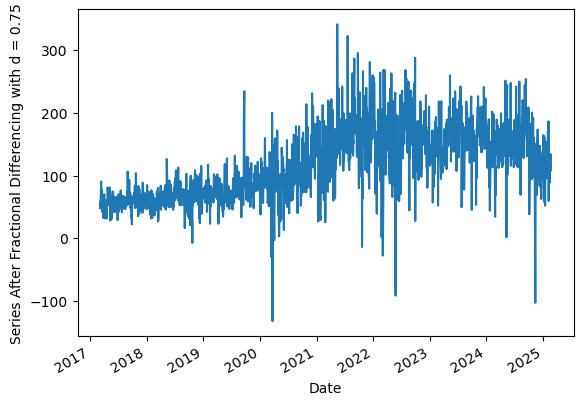

In [32]:
frac_diff_series.plot()
plt.ylabel("Series After Fractional Differencing with d = 0.75")

In [33]:
frac_diff_series.describe()

count    1968.000000
mean      116.575202
std        55.766781
min      -131.676032
25%        68.451093
50%       111.528851
75%       159.607558
max       340.877224
Name: Close, dtype: float64

In [34]:
adf_result_frac_diff_data = adfuller(frac_diff_series)
adf_statistic = adf_result_frac_diff_data[0] 
p_value = adf_result_frac_diff_data[1]
used_lags = adf_result_frac_diff_data[2] 
critical_values = adf_result_frac_diff_data[4] 

adf_statistic, p_value, used_lags, critical_values

(-2.1467805034032907,
 0.2261244665236818,
 26,
 {'1%': -3.4337235029383693,
  '5%': -2.8630302070982023,
  '10%': -2.56756332673476})

Note that for this fractional differenced series with d = 0.75, the adf_statistic is higher than the critical values. The p-value of 0.22 also indicates that this fractional differenced series is not stationary.

## Step 2 

Let us now build Multi-Layer Perceptron models to predict the future values of these time series. Specifically, we predict if the stock will rise or fall the next day.

**First, the original time series.** he inputs to this model will be the returns over the past 10, 60, 150 days along with the present value.

In [257]:
data = data.to_frame()

In [259]:
data["1d_returns"] = data.pct_change()

In [261]:
data.head()

,Close,1d_returns
Date,,
2017-02-20 00:00:00+05:30,920.973633,NaN
2017-02-21 00:00:00+05:30,935.839355,0.016141
2017-02-22 00:00:00+05:30,963.022583,0.029047
2017-02-23 00:00:00+05:30,952.357056,-0.011075
2017-02-27 00:00:00+05:30,945.702820,-0.006987


In [263]:
data["10d_returns"] = data["1d_returns"].rolling(10).apply(lambda x: (1+ x).prod())
data["60d_returns"] = data["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod())
data["150d_returns"] = data["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod())

In [264]:
data.dropna(inplace=True)

In [265]:
data.head()

,Close,1d_returns,10d_returns,60d_returns,150d_returns
Date,,,,,
2017-09-28 00:00:00+05:30,1068.423096,-0.025862,0.906866,1.019350,1.160102
2017-09-29 00:00:00+05:30,1070.030518,0.001504,0.908631,1.004483,1.143391
2017-10-03 00:00:00+05:30,1086.198608,0.015110,0.914686,1.014706,1.127906
2017-10-04 00:00:00+05:30,1091.162842,0.004570,0.920809,1.034605,1.145750
2017-10-05 00:00:00+05:30,1090.406006,-0.000694,0.932070,1.022611,1.153011


now, we create a separate column for the returns the next day. For this, we can simply shift the 1d_returns column by one day. We treat this as a classfication task and try to predict if the returns next dat will be positive or negative.

In [274]:
data["next_10d_returns"] = (data["10d_returns"].shift(10)>0).astype(int) #this is our target column. 
data.dropna(inplace=True)

In [276]:
data.head()

,Close,1d_returns,10d_returns,60d_returns,150d_returns,next_10d_returns
Date,,,,,,
2017-09-28 00:00:00+05:30,1068.423096,-0.025862,0.906866,1.019350,1.160102,0
2017-09-29 00:00:00+05:30,1070.030518,0.001504,0.908631,1.004483,1.143391,0
2017-10-03 00:00:00+05:30,1086.198608,0.015110,0.914686,1.014706,1.127906,0
2017-10-04 00:00:00+05:30,1091.162842,0.004570,0.920809,1.034605,1.145750,0
2017-10-05 00:00:00+05:30,1090.406006,-0.000694,0.932070,1.022611,1.153011,0


In [280]:
X = data[['1d_returns', '10d_returns', '60d_returns', '150d_returns']]
y = data['next_10d_returns']

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

Now to build the MLP

In [285]:
tf.keras.backend.clear_session()  # We clear the backend to reset the random seed process
tf.random.set_seed(42)

act_fun = "relu"
hp_units_1 = 4
hp_units_2 = 4
n_dropout = 0.2

In [286]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [287]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [291]:
y.value_counts()

next_10d_returns
1    1818
0      10
Name: count, dtype: int64

In [299]:
class_weight = {0: 180, 1: 1}

The output class seems pretty imbalanced. Let us balance the classes and fit the model.

In [301]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2,
    class_weight=class_weight
)

Epoch 1/50
37/37 - 2s - 56ms/step - accuracy: 0.9914 - loss: 3.1886 - val_accuracy: 1.0000 - val_loss: 0.2811
Epoch 2/50
37/37 - 0s - 8ms/step - accuracy: 0.9914 - loss: 2.2935 - val_accuracy: 1.0000 - val_loss: 0.2907
Epoch 3/50
37/37 - 0s - 7ms/step - accuracy: 0.9914 - loss: 2.7183 - val_accuracy: 1.0000 - val_loss: 0.2997
Epoch 4/50
37/37 - 0s - 7ms/step - accuracy: 0.9914 - loss: 2.8826 - val_accuracy: 1.0000 - val_loss: 0.3087
Epoch 5/50
37/37 - 0s - 7ms/step - accuracy: 0.9914 - loss: 2.7201 - val_accuracy: 1.0000 - val_loss: 0.3167
Epoch 6/50
37/37 - 0s - 10ms/step - accuracy: 0.9914 - loss: 2.7126 - val_accuracy: 1.0000 - val_loss: 0.3235
Epoch 7/50
37/37 - 0s - 7ms/step - accuracy: 0.9914 - loss: 2.4990 - val_accuracy: 1.0000 - val_loss: 0.3306
Epoch 8/50
37/37 - 0s - 7ms/step - accuracy: 0.9914 - loss: 2.3525 - val_accuracy: 1.0000 - val_loss: 0.3352
Epoch 9/50
37/37 - 0s - 6ms/step - accuracy: 0.9914 - loss: 2.4378 - val_accuracy: 1.0000 - val_loss: 0.3400
Epoch 10/50
37/37

In [303]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137 (552.00 B)

 Trainable params: 45 (180.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 92 (372.00 B)

In [308]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.4740 
Model accuracy in test:  [0.4927155077457428, 1.0]


**Now, let us similarly try to create a predictive model for the differenced series.**

In [354]:
differenced_data = differenced_data.to_frame()

In [373]:
differenced_data.head()

,Close
Date,
2017-02-21 00:00:00+05:30,14.865784
2017-02-22 00:00:00+05:30,27.183167
2017-02-23 00:00:00+05:30,-10.665588
2017-02-27 00:00:00+05:30,-6.654114
2017-02-28 00:00:00+05:30,21.000977


In [385]:
differenced_data["1d_returns"] = differenced_data["Close"].pct_change()
differenced_data["10d_returns"] = differenced_data["1d_returns"].rolling(10).apply(lambda x: (1 + x).prod())
differenced_data["60d_returns"] = differenced_data["1d_returns"].rolling(60).apply(lambda x: (1 + x).prod())
differenced_data["150d_returns"] = differenced_data["1d_returns"].rolling(150).apply(lambda x: (1 + x).prod())

In [393]:
differenced_data["next_10d_returns"] = (differenced_data["10d_returns"].shift(10)>0).astype(int)  #this is our target column. 

In [395]:
differenced_data.tail()

,Close,10d_returns,60d_returns,150d_returns,1d_returns,next_10d_returns
Date,,,,,,
2025-02-14 00:00:00+05:30,-5.099854,-0.100095,0.091806,-0.199555,-1.625756,1
2025-02-17 00:00:00+05:30,19.550049,-2.286542,0.443814,-0.855176,-4.833453,0
2025-02-18 00:00:00+05:30,-13.250000,-0.213365,1.060000,0.311202,-1.677748,0
2025-02-19 00:00:00+05:30,1.500000,-0.018951,0.033113,0.083709,-1.113208,0
2025-02-20 00:00:00+05:30,-4.200195,0.355947,0.320623,0.098074,-3.800130,0


In [399]:
differenced_data.dropna(inplace=True)

In [401]:
X = differenced_data[['1d_returns', '10d_returns', '60d_returns', '150d_returns']]
y = differenced_data['next_10d_returns']

In [403]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

In [405]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [407]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [409]:
y.value_counts()

next_10d_returns
0    583
1    579
Name: count, dtype: int64

the output class seems pretty balanced.

In [412]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2,
)

Epoch 1/50
24/24 - 3s - 129ms/step - accuracy: 0.4832 - loss: 3.1934 - val_accuracy: 0.4839 - val_loss: 1.7293
Epoch 2/50
24/24 - 0s - 10ms/step - accuracy: 0.4738 - loss: 3.4926 - val_accuracy: 0.4785 - val_loss: 1.7195
Epoch 3/50
24/24 - 0s - 9ms/step - accuracy: 0.4872 - loss: 3.2055 - val_accuracy: 0.4785 - val_loss: 1.7107
Epoch 4/50
24/24 - 0s - 9ms/step - accuracy: 0.4953 - loss: 2.9968 - val_accuracy: 0.4785 - val_loss: 1.7024
Epoch 5/50
24/24 - 0s - 8ms/step - accuracy: 0.5074 - loss: 3.2009 - val_accuracy: 0.4785 - val_loss: 1.6939
Epoch 6/50
24/24 - 0s - 8ms/step - accuracy: 0.4980 - loss: 3.1192 - val_accuracy: 0.4785 - val_loss: 1.6855
Epoch 7/50
24/24 - 0s - 9ms/step - accuracy: 0.4953 - loss: 2.9599 - val_accuracy: 0.4785 - val_loss: 1.6786
Epoch 8/50
24/24 - 0s - 9ms/step - accuracy: 0.4845 - loss: 3.2186 - val_accuracy: 0.4839 - val_loss: 1.6698
Epoch 9/50
24/24 - 0s - 9ms/step - accuracy: 0.4913 - loss: 2.8266 - val_accuracy: 0.4677 - val_loss: 1.6621
Epoch 10/50
24/2

In [414]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4443 - loss: 1.8630
Model accuracy in test:  [1.7708860635757446, 0.4763948619365692]


**Now, let us similarly try to create a predictive model for the fractionally differenced series.**

In [317]:
frac_diff_series = frac_diff_series.to_frame()

In [319]:
frac_diff_series["1d_returns"] = frac_diff_series.pct_change()

In [321]:
frac_diff_series["10d_returns"] = frac_diff_series["1d_returns"].rolling(10).apply(lambda x: (1+ x).prod())
frac_diff_series["60d_returns"] = frac_diff_series["1d_returns"].rolling(60).apply(lambda x: (1+ x).prod())
frac_diff_series["150d_returns"] = frac_diff_series["1d_returns"].rolling(150).apply(lambda x: (1+ x).prod())

In [325]:
frac_diff_series.dropna(inplace=True)

In [327]:
frac_diff_series["next_10d_returns"] = (frac_diff_series["10d_returns"].shift(10)>0).astype(int) #this is our target column. 
frac_diff_series.dropna(inplace=True)

In [329]:
X = frac_diff_series[['1d_returns', '10d_returns', '60d_returns', '150d_returns']]
y = frac_diff_series['next_10d_returns']

In [331]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) #train-test split

In [333]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=hp_units_1, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
model.add(tf.keras.layers.Dropout(n_dropout))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid")) #activation function

In [335]:
hp_lr = 1e-4  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

In [337]:
y.value_counts()

next_10d_returns
1    1788
0      30
Name: count, dtype: int64

In [341]:
class_weight = {0: 60, 1: 1} #balancing the classes

In [343]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=2,
    class_weight=class_weight
)

Epoch 1/50
37/37 - 3s - 72ms/step - accuracy: 0.7309 - loss: 5.0496 - val_accuracy: 0.9588 - val_loss: 0.5061
Epoch 2/50
37/37 - 0s - 7ms/step - accuracy: 0.7584 - loss: 2.8199 - val_accuracy: 0.9553 - val_loss: 0.5081
Epoch 3/50
37/37 - 0s - 7ms/step - accuracy: 0.7360 - loss: 4.4544 - val_accuracy: 0.9553 - val_loss: 0.5108
Epoch 4/50
37/37 - 0s - 7ms/step - accuracy: 0.7231 - loss: 4.9405 - val_accuracy: 0.9519 - val_loss: 0.5132
Epoch 5/50
37/37 - 0s - 6ms/step - accuracy: 0.7334 - loss: 4.2993 - val_accuracy: 0.9485 - val_loss: 0.5156
Epoch 6/50
37/37 - 0s - 7ms/step - accuracy: 0.7317 - loss: 3.3569 - val_accuracy: 0.9450 - val_loss: 0.5178
Epoch 7/50
37/37 - 0s - 7ms/step - accuracy: 0.7334 - loss: 2.3274 - val_accuracy: 0.9450 - val_loss: 0.5196
Epoch 8/50
37/37 - 0s - 6ms/step - accuracy: 0.7283 - loss: 3.5670 - val_accuracy: 0.9416 - val_loss: 0.5217
Epoch 9/50
37/37 - 0s - 7ms/step - accuracy: 0.7077 - loss: 2.9924 - val_accuracy: 0.9416 - val_loss: 0.5238
Epoch 10/50
37/37 

In [345]:
y_prob = model.predict(X_test)
y_pred = np.where(y_prob > 0.50, 1, 0)

acc = model.evaluate(X_test, y_test)
print("Model accuracy in test: ", acc) #outputs the loss and the accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7502 - loss: 0.6123 
Model accuracy in test:  [0.5998312830924988, 0.7692307829856873]


**Of the three series, the MLP model gets the best test accuracy for the original time series and the worst for the differenced time series. This counter-intuitively shows that removing the trend from the time series is probably not a good idea. However, let us now proceed to build our CNN model and see how it fares.**

## Step 3 